In [1]:
# =============================================================================
# SECCIÓN 1: INSTALACIÓN DE DEPENDENCIAS CON UV
# =============================================================================
import shutil

# Instalamos 'uv' en el sistema si no existe
if shutil.which("uv") is None:
    !pip install uv -q

# Utilizamos uv para instalar las librerías del proyecto de forma ultra rápida
!uv pip install --system pandas numpy torch pygad scikit-learn matplotlib seaborn tqdm

Using Python 3.12.12 environment at: /usr
Resolved 48 packages in 488ms
Prepared 1 package in 21ms
Installed 1 package in 7ms
 + pygad==3.5.0


In [2]:
# =============================================================================
# SECCIÓN 2: CARGA DE DATOS Y DESCARGA DE MÁSCARA (REMOTE ➔ LOCAL)
# =============================================================================

import torch
import os
import requests
import numpy as np

# 1. Configuración de Rutas y URLs
BASE_RAW_PROCESSED = "https://raw.githubusercontent.com/berniehans/ProjectEvo-Callao-Safety/main/data_processed/"
BASE_RAW_DATA = "https://raw.githubusercontent.com/berniehans/ProjectEvo-Callao-Safety/main/models/"

LOCAL_PROCESSED_DIR = "data_processed/"
LOCAL_MODELS_DIR = "models/"

os.makedirs(LOCAL_PROCESSED_DIR, exist_ok=True)
os.makedirs(LOCAL_MODELS_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Usando: {torch.cuda.get_device_name(0)}")

def download_file(url_base, filename, destination_folder):
    url = url_base + filename
    local_path = os.path.join(destination_folder, filename)

    print(f"📥 Descargando {filename}...", end=" ")
    response = requests.get(url)
    if response.status_code == 200:
        with open(local_path, "wb") as f:
            f.write(response.content)
        print("✅ Hecho")
    else:
        print(f"❌ Error {response.status_code}")

# 2. Descargar Metadatos y Shards (Fase 2)
download_file(BASE_RAW_PROCESSED, "metadata.pt", LOCAL_PROCESSED_DIR)
meta = torch.load(os.path.join(LOCAL_PROCESSED_DIR, 'metadata.pt'), weights_only=False)

for i in range(1, meta['total_chunks'] + 1):
    part_name = f"bert_embeddings_part_{i}.pt"
    download_file(BASE_RAW_PROCESSED, part_name, LOCAL_PROCESSED_DIR)

# 3. Descargar Máscara de Características (Fase 3)
# Se descarga desde la carpeta /data de tu GitHub
download_file(BASE_RAW_DATA, "ga_feature_mask.pt", LOCAL_MODELS_DIR)

# 4. Re-ensamblaje y Aplicación de Máscara
X_list, y_list = [], []
for i in range(1, meta['total_chunks'] + 1):
    chunk = torch.load(os.path.join(LOCAL_PROCESSED_DIR, f'bert_embeddings_part_{i}.pt'), weights_only=False)
    X_list.append(chunk['embeddings'])
    y_list.append(chunk['labels'])

X_all = torch.cat(X_list, dim=0)
y_all = torch.cat(y_list, dim=0)

# Cargar máscara y aplicarla
mask_data = torch.load(os.path.join(LOCAL_MODELS_DIR, 'ga_feature_mask.pt'), weights_only=False)
mask = torch.tensor(mask_data['best_mask'], device=device).bool()

# Filtrar características y subir a GPU en precisión media (FP16)
X_reduced = X_all[:, mask.cpu()].to(device).float()
y_gpu = y_all.to(device).long()

print("="*50)
print(f"✅ CARGA COMPLETA")
print(f"Vectores Originales: 768 dimensiones")
print(f"Vectores Reducidos (GA): {X_reduced.shape[1]} dimensiones")
print(f"Registros listos para NAS: {X_reduced.shape[0]}")
print("="*50)

🚀 Usando: Tesla T4
📥 Descargando metadata.pt... ✅ Hecho
📥 Descargando bert_embeddings_part_1.pt... ✅ Hecho
📥 Descargando bert_embeddings_part_2.pt... ✅ Hecho
📥 Descargando bert_embeddings_part_3.pt... ✅ Hecho
📥 Descargando bert_embeddings_part_4.pt... ✅ Hecho
📥 Descargando ga_feature_mask.pt... ✅ Hecho
✅ CARGA COMPLETA
Vectores Originales: 768 dimensiones
Vectores Reducidos (GA): 92 dimensiones
Registros listos para NAS: 98458


In [3]:
# =============================================================================
# SECCIÓN 3: CLASE MODELO DINÁMICO (NAS COMPATIBLE)
# =============================================================================
import torch.nn as nn

class NASClassifier(nn.Module):
    def __init__(self, input_dim, n_layers, neurons, dropout, output_dim):
        super(NASClassifier, self).__init__()
        layers = []
        in_features = input_dim

        # El GA decide n_layers
        for i in range(int(n_layers)):
            layers.append(nn.Linear(in_features, int(neurons)))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_features = int(neurons)

        layers.append(nn.Linear(in_features, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [4]:
# =============================================================================
# SECCIÓN 4: FITNESS FUNCTION OPTIMIZADA (FP32 + 20 ÉPOCAS)
# =============================================================================
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch

# Índices de clases críticas
CRITICAL_INDICES = [3, 4, 5]

def fitness_func(ga_instance, solution, solution_idx):
    try:
        # Decodificar genes
        n_layers, neurons, dropout, lr, alpha = solution

        # 1. División interna (Train/Val) 80/20
        indices = torch.randperm(X_reduced.size(0))
        split = int(0.8 * len(indices))
        train_idx, val_idx = indices[:split], indices[split:]

        # 2. DataLoader: Batches de 2048 para velocidad
        train_loader = DataLoader(
            TensorDataset(X_reduced[train_idx].float(), y_gpu[train_idx]),
            batch_size=2048,
            shuffle=True
        )

        # 3. Construcción del Modelo (Float32)
        model = NASClassifier(
            input_dim=X_reduced.shape[1],
            n_layers=int(n_layers),
            neurons=int(neurons),
            dropout=float(dropout),
            output_dim=len(meta['class_names'])
        ).to(device).float()

        # 4. Configuración de Pesos (Estabilizados)
        class_weights = torch.ones(len(meta['class_names']), device=device).float()
        for idx in CRITICAL_INDICES:
            class_weights[idx] = float(alpha)

        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = torch.optim.Adam(model.parameters(), lr=float(lr))

        # 5. Entrenamiento (Aumentado a 20 épocas para convergencia)
        model.train()
        for epoch in range(20):
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        # 6. Evaluación en Validación
        model.eval()
        with torch.no_grad():
            val_X = X_reduced[val_idx].float()
            val_y = y_gpu[val_idx].cpu().numpy()
            preds = torch.argmax(model(val_X), dim=1).cpu().numpy()

        f1 = f1_score(val_y, preds, average='macro', zero_division=0)

        # Penalización ligera por complejidad
        penalty = 0.002 * n_layers

        # Limpieza de memoria
        del model, optimizer, criterion
        torch.cuda.empty_cache()

        return float(f1 - penalty)

    except Exception as e:
        print(f"⚠️ Error en gen {solution_idx}: {e}")
        return 0.0

In [5]:
# =============================================================================
# SECCIÓN 5: EJECUCIÓN DEL NAS (CONFIGURACIÓN ESTABLE)
# =============================================================================
import pygad
import numpy as np
from tqdm.auto import tqdm

# Espacio de búsqueda refinado (Basado en tu Sanity Check exitoso)
gene_space = [
    [1, 2, 3],                  # Capas
    [128, 256, 512],            # Neuronas (Suficiente capacidad)
    [0.2, 0.3, 0.4],            # Dropout
    [0.001, 0.0005],            # LR (Eliminamos 0.0001 porque es muy lento)
    [2.0, 3.0, 5.0, 8.0]        # Alpha (Pesos razonables, eliminamos 20 y 50)
]

n_gen = 30
pbar = tqdm(total=n_gen, desc="🧠 Evolucionando Arquitectura")

def on_generation(ga_instance):
    pbar.update(1)
    if ga_instance.last_generation_fitness is not None:
        best_f1 = np.max(ga_instance.last_generation_fitness)
        pbar.set_postfix({"Best F1": f"{best_f1:.4f}"})

ga_nas = pygad.GA(
    num_generations=n_gen,
    sol_per_pop=12,             # Población un poco más pequeña para ir rápido
    num_parents_mating=4,
    fitness_func=fitness_func,
    num_genes=len(gene_space),
    gene_space=gene_space,
    parent_selection_type="tournament",
    K_tournament=3,
    crossover_type="uniform",
    mutation_type="random",
    mutation_percent_genes=25,
    on_generation=on_generation,
    keep_elitism=2
)

print(f"🔥 Iniciando Neuro-Evolución (Modo Corregido)...")
# Aseguramos limpieza de datos antes de empezar
if torch.isnan(X_reduced).any():
    X_reduced = torch.nan_to_num(X_reduced, nan=0.0)

try:
    ga_nas.run()
except Exception as e:
    print(f"❌ Error durante la ejecución: {e}")
finally:
    pbar.close()

🧠 Evolucionando Arquitectura:   0%|          | 0/30 [00:00<?, ?it/s]

🔥 Iniciando Neuro-Evolución (Modo Corregido)...



🏆 MEJOR ARQUITECTURA ENCONTRADA
🔹 Capas Ocultas: 3.0
🔹 Neuronas por Capa: 512.0
🔹 Dropout: 0.3
🔹 Learning Rate: 0.001
🔹 Peso de Clase Crítica (Alpha): 3.0
🔹 Fitness Final: 0.5209


/usr/local/lib/python3.12/dist-packages/pygad/visualize/plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


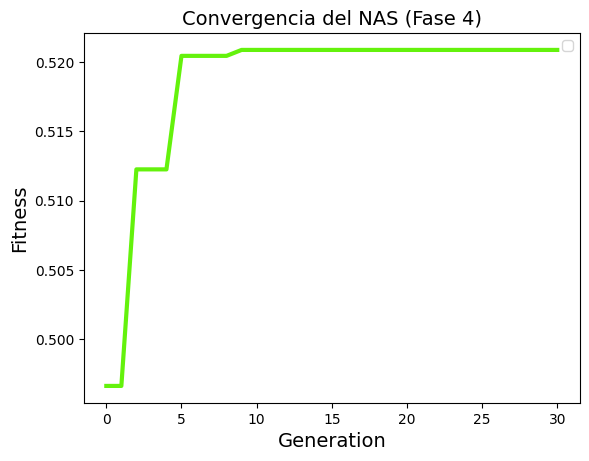


💾 Configuración NAS guardada exitosamente.


In [6]:
# =============================================================================
# SECCIÓN 6: ANÁLISIS DE RESULTADOS Y PERSISTENCIA
# =============================================================================
solution, fitness, _ = ga_nas.best_solution()

print("\n" + "="*30)
print("🏆 MEJOR ARQUITECTURA ENCONTRADA")
print("="*30)
print(f"🔹 Capas Ocultas: {solution[0]}")
print(f"🔹 Neuronas por Capa: {solution[1]}")
print(f"🔹 Dropout: {solution[2]}")
print(f"🔹 Learning Rate: {solution[3]}")
print(f"🔹 Peso de Clase Crítica (Alpha): {solution[4]}")
print(f"🔹 Fitness Final: {fitness:.4f}")

# Graficar Convergencia
ga_nas.plot_fitness(title="Convergencia del NAS (Fase 4)")

# Guardar configuración para el Ensemble (Fase 5)
config_final = {
    'best_solution': solution,
    'class_names': meta['class_names'],
    'feature_mask': mask.cpu()
}
torch.save(config_final, 'models/best_nas_config.pt')
print("\n💾 Configuración NAS guardada exitosamente.")

🥊 INICIANDO COMPETENCIA DE ARQUITECTURAS...

🏃 Entrenando modelo: Ligero (1x128)...

🏃 Entrenando modelo: Medio (2x256)...

🏃 Entrenando modelo: Pesado (3x512)...

✅ Competencia finalizada.


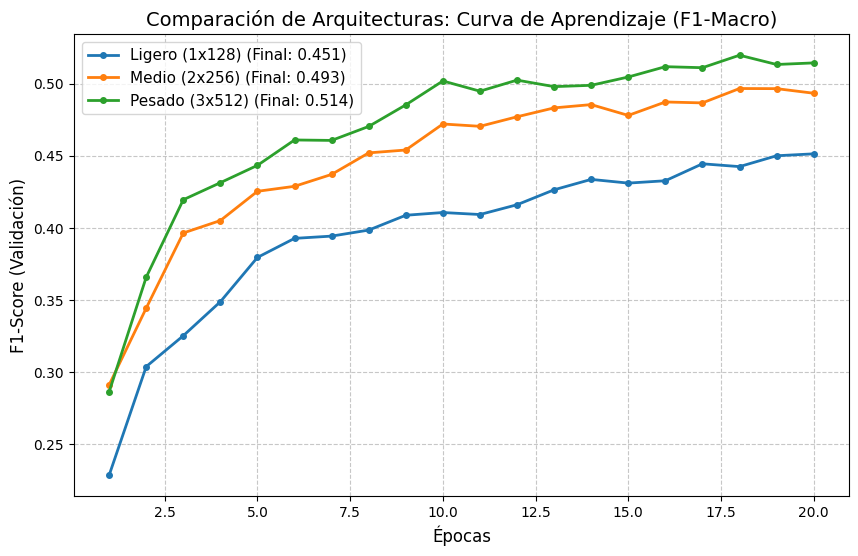

In [7]:
# =============================================================================
# EXPERIMENTO DE VALIDACIÓN: COMPETENCIA DE ARQUITECTURAS
# =============================================================================
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score

print("🥊 INICIANDO COMPETENCIA DE ARQUITECTURAS...")

# 1. Configuración Común (Igualdad de condiciones)
# Usamos un LR y Alpha "seguros" para ver quién aprende mejor por pura estructura
FIXED_LR = 0.001
FIXED_ALPHA = 3.0
EPOCHS = 20
BATCH_SIZE = 2048

# Definimos los contendientes
contenders = [
    {"name": "Ligero (1x128)", "n_layers": 1, "neurons": 128},
    {"name": "Medio (2x256)",  "n_layers": 2, "neurons": 256},
    {"name": "Pesado (3x512)", "n_layers": 3, "neurons": 512}
]

# Preparar datos (80% Train, 20% Val)
indices = torch.randperm(X_reduced.size(0))
split = int(0.8 * len(indices))
train_idx, val_idx = indices[:split], indices[split:]

train_loader = DataLoader(TensorDataset(X_reduced[train_idx].float(), y_gpu[train_idx]), batch_size=BATCH_SIZE, shuffle=True)
X_val = X_reduced[val_idx].float()
y_val = y_gpu[val_idx].cpu().numpy()

# Pesos de clase
class_weights = torch.ones(len(meta['class_names']), device=device).float()
for idx in [3, 4, 5]: class_weights[idx] = FIXED_ALPHA
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Diccionario para guardar historias
history = {c["name"]: [] for c in contenders}

# 2. Bucle de Entrenamiento Comparativo
for c in contenders:
    print(f"\n🏃 Entrenando modelo: {c['name']}...")

    # Instanciar modelo
    model = NASClassifier(
        input_dim=X_reduced.shape[1],
        n_layers=c["n_layers"],
        neurons=c["neurons"],
        dropout=0.3, # Dropout fijo
        output_dim=len(meta['class_names'])
    ).to(device).float()

    optimizer = torch.optim.Adam(model.parameters(), lr=FIXED_LR)

    # Entrenar
    model.train()
    for epoch in range(EPOCHS):
        for bx, by in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(bx), by)
            loss.backward()
            optimizer.step()

        # Evaluar en cada época para la gráfica
        model.eval()
        with torch.no_grad():
            preds = torch.argmax(model(X_val), dim=1).cpu().numpy()

        f1 = f1_score(y_val, preds, average='macro', zero_division=0)
        history[c["name"]].append(f1)

        model.train() # Volver a modo train

print("\n✅ Competencia finalizada.")

# 3. La Demostración Perceptible (GRÁFICA)
plt.figure(figsize=(10, 6))
for name, scores in history.items():
    plt.plot(range(1, EPOCHS+1), scores, label=f"{name} (Final: {scores[-1]:.3f})", linewidth=2, marker='o', markersize=4)

plt.title("Comparación de Arquitecturas: Curva de Aprendizaje (F1-Macro)", fontsize=14)
plt.xlabel("Épocas", fontsize=12)
plt.ylabel("F1-Score (Validación)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=11)
plt.show()

⚔️ INICIANDO STRESS TEST DE 5 NIVELES...

🏋️ Nano (1x128) | Parámetros: 12,936
   🏁 F1 Final: 0.4623

🏋️ Standard (2x256) | Parámetros: 91,656
   🏁 F1 Final: 0.5014

🏋️ Large (3x512) | Parámetros: 577,032
   🏁 F1 Final: 0.5193

🏋️ X-Large (4x512) | Parámetros: 839,688
   🏁 F1 Final: 0.5195

🏋️ Massive (3x1024) | Parámetros: 2,202,632
   🏁 F1 Final: 0.5342


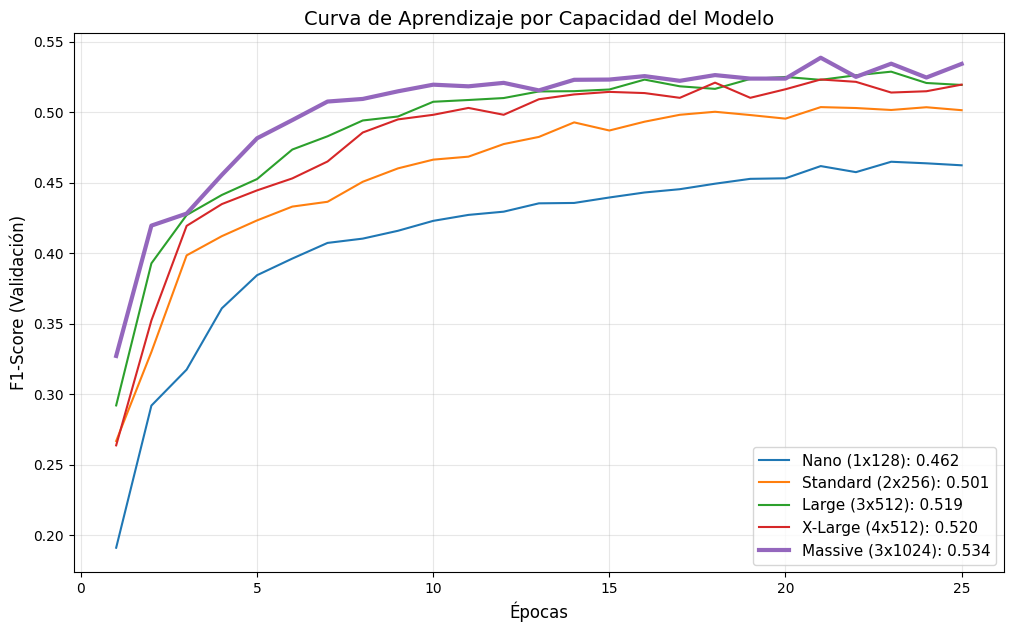


🏆 GANADOR INDISCUTIBLE: Massive (3x1024)
Este es el modelo que usaremos como base para la optimización final.


In [8]:
# =============================================================================
# EXPERIMENTO DEFINITIVO: STRESS TEST DE ARQUITECTURAS
# =============================================================================
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np

print("⚔️ INICIANDO STRESS TEST DE 5 NIVELES...")

# 1. Configuración de Control (Igualdad de condiciones)
FIXED_LR = 0.001
FIXED_ALPHA = 3.0
EPOCHS = 25          # Subimos a 25 para dar tiempo a las redes grandes
BATCH_SIZE = 2048
DROPOUT = 0.3        # Dropout moderado para todos

# 2. Los 5 Contendientes
contenders = [
    {"name": "Nano (1x128)",    "n_layers": 1, "neurons": 128},
    {"name": "Standard (2x256)","n_layers": 2, "neurons": 256},
    {"name": "Large (3x512)",   "n_layers": 3, "neurons": 512},
    {"name": "X-Large (4x512)", "n_layers": 4, "neurons": 512},
    {"name": "Massive (3x1024)","n_layers": 3, "neurons": 1024}
]

# Preparar datos (80% Train, 20% Val)
indices = torch.randperm(X_reduced.size(0))
split = int(0.8 * len(indices))
train_idx, val_idx = indices[:split], indices[split:]

# Convertir a float32 para estabilidad
X_train = X_reduced[train_idx].float()
y_train = y_gpu[train_idx].long()
X_val = X_reduced[val_idx].float()
y_val = y_gpu[val_idx].cpu().numpy()

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)

# Pesos de clase
class_weights = torch.ones(len(meta['class_names']), device=device).float()
for idx in [3, 4, 5]: class_weights[idx] = FIXED_ALPHA
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Historial
history = {c["name"]: [] for c in contenders}
final_scores = {}

# 3. Bucle de Entrenamiento
for c in contenders:
    # Instanciar
    model = NASClassifier(
        input_dim=X_reduced.shape[1],
        n_layers=c["n_layers"],
        neurons=c["neurons"],
        dropout=DROPOUT,
        output_dim=len(meta['class_names'])
    ).to(device).float()

    # Contar parámetros (para el informe)
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\n🏋️ {c['name']} | Parámetros: {n_params:,}")

    optimizer = torch.optim.Adam(model.parameters(), lr=FIXED_LR)

    # Entrenar
    model.train()
    for epoch in range(EPOCHS):
        for bx, by in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(bx), by)
            loss.backward()
            optimizer.step()

        # Evaluar
        model.eval()
        with torch.no_grad():
            preds = torch.argmax(model(X_val), dim=1).cpu().numpy()

        f1 = f1_score(y_val, preds, average='macro', zero_division=0)
        history[c["name"]].append(f1)
        model.train()

    final_scores[c["name"]] = history[c["name"]][-1]
    print(f"   🏁 F1 Final: {history[c['name']][-1]:.4f}")

# 4. Visualización de Resultados
plt.figure(figsize=(12, 7))
for name, scores in history.items():
    # Destacar al ganador
    width = 3 if scores[-1] == max(final_scores.values()) else 1.5
    plt.plot(range(1, EPOCHS+1), scores, label=f"{name}: {scores[-1]:.3f}", linewidth=width)

plt.title("Curva de Aprendizaje por Capacidad del Modelo", fontsize=14)
plt.xlabel("Épocas", fontsize=12)
plt.ylabel("F1-Score (Validación)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11, loc='lower right')
plt.show()

# Recomendación Automática
winner = max(final_scores, key=final_scores.get)
print(f"\n🏆 GANADOR INDISCUTIBLE: {winner}")
print("Este es el modelo que usaremos como base para la optimización final.")